In [72]:
import torch
from chestxray_module.lungsegmodels import PretrainedUNet
from chestxray_module.dataset import clean_data, data_load, add_split_class, get_split, load_split
import numpy as np
from monai.transforms import Compose, Transform, LoadImage, EnsureChannelFirst, Lambda, RepeatChannel, Resize, SpatialPad, ScaleIntensity, NormalizeIntensity, RandRotate, RandAffine, RandFlip, RandGaussianNoise
from monai.data import Dataset

import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHTS_PATH = "/home/ramy/Ramy/chestxray/unet-6v.pt"

model = PretrainedUNet(in_channels=1, out_channels=2, batch_norm=True).to(DEVICE)

state = torch.load(WEIGHTS_PATH, map_location="cpu")
model.load_state_dict(state)

model.eval()
print("Loaded OK")
print("DEVICE:", DEVICE)
print("init_conv weight shape:", model.init_conv.weight.shape)
print("batch_norm:", model.batch_norm)
print("out layer:", model.out)

/home/ramy/miniforge3/envs/medical_imaging/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ramy/miniforge3/envs/medical_imaging/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded OK
DEVICE: cpu
init_conv weight shape: torch.Size([3, 1, 1, 1])
batch_norm: True
out layer: Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))


In [73]:
import os
print(os.getcwd())
root_path = r"/home/ramy/Ramy/chestxray"  # Use 'r' before the string to avoid slash errors
os.chdir(root_path)
print(f"Current Directory: {os.getcwd()}")

/home/ramy/Ramy/chestxray
Current Directory: /home/ramy/Ramy/chestxray


[INFO] data/interim/cleaned_data already exists.
Dataset size: 14373 images
Sample 14145: shape=(3, 1798, 1130), dtype=torch.float32, min=0.00, max=255.00
Sample 13137: shape=(3, 1024, 1024), dtype=torch.float32, min=0.00, max=255.00
Sample 8866: shape=(3, 256, 256), dtype=torch.float32, min=0.00, max=255.00


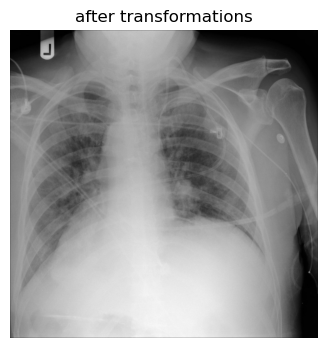

raw type: <class 'monai.data.meta_tensor.MetaTensor'>
raw shape: torch.Size([3, 1024, 1024])
after channel fix: torch.Size([1, 1024, 1024])
img_b: torch.Size([1, 1, 1024, 1024]) torch.float32
value range: 0.0 255.0 139.40219116210938
img01 shape: torch.Size([1, 1, 1024, 1024]) torch.float32
img01 range: 0.0 1.0 0.5466752648353577


In [133]:
clean_data()
raw_data = data_load(data_dir='data/interim/cleaned_data', inspect=True)
# transformed_data = transform(raw_data, "train")
labeled_data = add_split_class(raw_data)
split_data = get_split(labeled_data, "train")
split_data[3526]


# img0_hwc = labeled_data[0].permute(1, 2, 0).cpu().numpy()
img0_hwc = split_data[1020]["image"].permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(4,4))
plt.imshow(np.rot90(img0_hwc.astype("uint8"),k=3))
plt.axis("off")
plt.title("after transformations")
plt.show()

i = 1020
sample = split_data[i]
img = sample["image"]


print("raw type:", type(img))
print("raw shape:", img.shape if torch.is_tensor(img) else "not a tensor")

# Ensure tensor, float32
img = torch.as_tensor(img).float()


# Make it (1, H, W)
if img.ndim == 2:
    img = img.unsqueeze(0)          # (1,H,W)
elif img.ndim == 3:
    # If HWC -> CHW
    if img.shape[0] not in (1, 3):
        img = img.permute(2, 0, 1)
    # If 3 channels, keep ONLY one (model expects 1 channel)
    if img.shape[0] == 3:
        img = img[:1]
        
print("after channel fix:", img.shape)

# Add batch dimension -> (1,1,H,W)
img_b = img.unsqueeze(0)

print("img_b:", img_b.shape, img_b.dtype)
print("value range:", img_b.min().item(), img_b.max().item(), img_b.mean().item())


# Scale to [0, 1]
img01 = img_b / 255.0

print("img01 shape:", img01.shape, img01.dtype)
print("img01 range:", img01.min().item(), img01.max().item(), img01.mean().item())


In [134]:
with torch.no_grad():
    logits = model(img01.to(DEVICE))

print("logits type:", type(logits))
print("logits shape:", logits.shape)
print(
    "logits stats (min, max, mean):",
    logits.min().item(),
    logits.max().item(),
    logits.mean().item(),
)


logits type: <class 'monai.data.meta_tensor.MetaTensor'>
logits shape: torch.Size([1, 2, 1024, 1024])
logits stats (min, max, mean): -4.683808326721191 5.718170166015625 0.42719435691833496


In [135]:
import torch
T = 1
probs_T = torch.softmax(logits/T, dim=1)

bg = probs_T[0, 0].detach().cpu()
lung_T = probs_T[0, 1].detach().cpu()


print("bg prob stats (min, max, mean):",
      bg.min().item(), bg.max().item(), bg.mean().item())

print("lung prob stats (min, max, mean):",
      lung_T.min().item(), lung_T.max().item(), lung_T.mean().item())




bg prob stats (min, max, mean): 0.47479137778282166 0.9999696016311646 0.9987157583236694
lung prob stats (min, max, mean): 3.0371407774509862e-05 0.5252086520195007 0.0012841805582866073


In [136]:
# Hard prediction: class with highest probability
pred_class = probs_T.argmax(dim=1)   # (1, H, W)

# Fraction of pixels predicted as lung (class 1)
lung_fraction = (pred_class == 1).float().mean().item()

print("Predicted lung pixel fraction:", lung_fraction)


Predicted lung pixel fraction: 1.049041748046875e-05


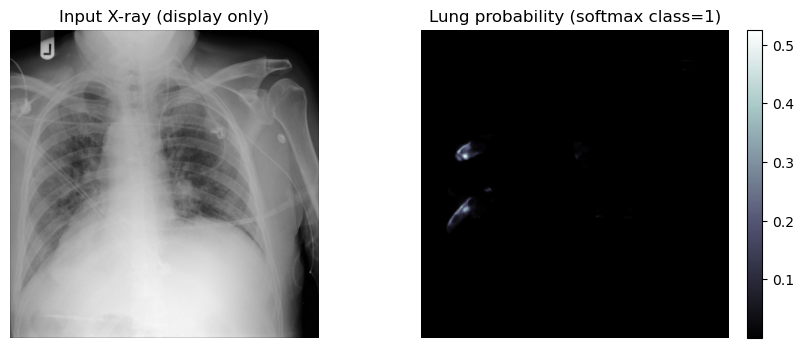

In [137]:
import matplotlib.pyplot as plt

# Prepare input for display (min-max only for visualization)
x = img01[0, 0].detach().cpu()
x_vis = (x - x.min()) / (x.max() - x.min() + 1e-8)

lung_vis = lung_T  # already in [0,1]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
#plt.imshow(x_vis, cmap="gray")
plt.imshow(np.rot90(x_vis, k=3), cmap="gray")
plt.title("Input X-ray (display only)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(np.rot90(lung_vis, k=3), cmap="bone")
plt.title("Lung probability (softmax class=1)")
plt.colorbar(fraction=0.046)
plt.axis("off")
plt.savefig("segmentation_attempt4.png", dpi=200, bbox_inches="tight")

#plt.tight_layout()
plt.show()

